In [32]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta
from statsmodels.tsa.arima_model import ARIMA
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.ndimage.filters import gaussian_filter
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [39]:
import matplotlib.dates as mdates

def arima_model(series, data_split, params, future_periods, log):
    
    # log transformation of data if user selects log as true
    if log == True:
        series_dates = series.index
        series = pd.Series(np.log(series), index=series.index)
       
    # create training and testing data sets based on user split fraction
    size = int(len(series) * data_split)
    train, test = series[0:size], series[size:len(series)]
    history = [val for val in train]
    predictions = []

    # creates a rolling forecast by testing one value from the test set, and then add that test value
    # to the model training, followed by testing the next test value in the series
    for t in range(len(test)):
        model = ARIMA(history, order=(params[0], params[1], params[2]))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat[0])
        obs = test[t]
        history.append(obs)
    
    # forecasts future periods past the input testing series based on user input
    future_forecast = model_fit.forecast(future_periods)[0]
    future_dates = [test.index[-1]+timedelta(i*365/12) for i in range(1, future_periods+1)]
    test_dates = test.index
    
    # if the data was originally log transformed, the inverse transformation is performed
    if log == True:
        predictions = np.exp(predictions)
        test = pd.Series(np.exp(test), index=test_dates)
        future_forecast = np.exp(future_forecast)
    
    # creates pandas series with datetime index for the predictions and forecast values
    forecast = pd.Series(future_forecast, index=future_dates)
    predictions = pd.Series(predictions, index=test_dates)
    
    # generates plots to compare the predictions for out-of-sample data to the actual test values
    fig = plt.figure()
    ax = fig.add_subplot(111)
    myFmt = mdates.DateFormatter('%m%/%y')
    ax.xaxis.set_major_formatter(myFmt)
    plt.plot(predictions, c='red')
    plt.plot(test)
    plt.show()
    
    # calculates root mean squared errors (RMSEs) for the out-of-sample predictions
    error = np.sqrt(mean_squared_error(predictions, test))
    print('Test RMSE: %.3f' % error)
    
    return predictions, test, future_forecast

In [24]:
def create_dataset(data_series, look_back, split_frac, transforms):
    
    # log transforming that data, if necessary
    if transforms[0] == True:
        dates = data_series.index
        data_series = pd.Series(np.log(data_series), index=dates)
    
    # differencing data, if necessary
    if transforms[1] == True:
        dates = data_series.index
        data_series = pd.Series(data_series - data_series.shift(1), index=dates).dropna()

    # scaling values between 0 and 1
    dates = data_series.index
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_series.values.reshape(-1, 1))
    data_series = pd.Series(scaled_data[:, 0], index=dates)
    
    # creating targets and features by shifting values by 'i' number of time periods
    df = pd.DataFrame()
    for i in range(look_back+1):
        label = ''.join(['t-', str(i)])
        df[label] = data_series.shift(i)
    df = df.dropna()
    print(df.tail())
    
    # splitting data into train and test sets
    size = int(split_frac*df.shape[0])
    train = df[:size]
    test = df[size:]
    
    # creating target and features for training set
    X_train = train.iloc[:, 1:].values
    y_train = train.iloc[:, 0].values
    train_dates = train.index
    
    # creating target and features for test set
    X_test = test.iloc[:, 1:].values
    y_test = test.iloc[:, 0].values
    test_dates = test.index
    
    # reshaping data into 3 dimensions for modeling with the LSTM neural net
    X_train = np.reshape(X_train, (X_train.shape[0], 1, look_back))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, look_back))
    
    return X_train, y_train, X_test, y_test, train_dates, test_dates, scaler

In [25]:
def inverse_transforms(train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler):
    
    # inverse 0 to 1 scaling
    train_predict = pd.Series(scaler.inverse_transform(train_predict.reshape(-1,1))[:,0], index=train_dates)
    y_train = pd.Series(scaler.inverse_transform(y_train.reshape(-1, 1))[:,0], index=train_dates)

    test_predict = pd.Series(scaler.inverse_transform(test_predict.reshape(-1, 1))[:,0], index=test_dates)
    y_test = pd.Series(scaler.inverse_transform(y_test.reshape(-1, 1))[:,0], index=test_dates)
    
    # reversing differencing if log transformed as well
    if (transforms[1] == True) & (transforms[0] == True):
        train_predict = pd.Series(train_predict + np.log(data_series.shift(1)), index=train_dates).dropna()
        y_train = pd.Series(y_train + np.log(data_series.shift(1)), index=train_dates).dropna()

        test_predict = pd.Series(test_predict + np.log(data_series.shift(1)), index=test_dates).dropna()
        y_test = pd.Series(y_test + np.log(data_series.shift(1)), index=test_dates).dropna()
    
    # reversing differencing if no log transform
    elif transforms[1] == True:
        train_predict = pd.Series(train_predict + data_series.shift(1), index=train_dates).dropna()
        y_train = pd.Series(y_train + data_series.shift(1), index=train_dates).dropna()

        test_predict = pd.Series(test_predict + data_series.shift(1), index=test_dates).dropna()
        y_test = pd.Series(y_test + data_series.shift(1), index=test_dates).dropna()
      
    # reversing log transformation
    if transforms[0] == True:
        train_predict = pd.Series(np.exp(train_predict), index=train_dates)
        y_train = pd.Series(np.exp(y_train), index=train_dates)

        test_predict = pd.Series(np.exp(test_predict), index=test_dates)
        y_test = pd.Series(np.exp(y_test), index=test_dates)
        
    return train_predict, y_train, test_predict, y_test

In [43]:
def lstm_model(data_series, look_back, split, transforms, lstm_params):
    np.random.seed(1)
    
    # creating the training and testing datasets
    X_train, y_train, X_test, y_test, train_dates, test_dates, scaler = create_dataset(data_series, look_back, split, transforms)

    # training the model
    model = Sequential()
    model.add(LSTM(lstm_params[0], input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=lstm_params[1], batch_size=1, verbose=lstm_params[2])
    
    # making predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # inverse transforming results
    train_predict, y_train, test_predict, y_test = \
    inverse_transforms(train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler)
    
    # plot of predictions and actual values
    fig = plt.figure()
    ax = fig.add_subplot(111)
    myFmt = mdates.DateFormatter('%m%/%y')
    ax.xaxis.set_major_formatter(myFmt)
    plt.plot(y_test)
    plt.plot(test_predict, color='red')
    plt.show()
    
    # calculating RMSE metrics
    error = np.sqrt(mean_squared_error(train_predict, y_train))
    print('Train RMSE: %.3f' % error)
    error = np.sqrt(mean_squared_error(test_predict, y_test))
    print('Test RMSE: %.3f' % error)
    
    return train_predict, y_train, test_predict, y_test

In [42]:
def gauss_compare(original_series, predictions, data_split):
    
    # the train/test split used to generate the Gaussian-filtered predictions
    size = int(len(original_series)*data_split)

    # creating a plot of the original series and Gaussian-filtered predictions
    fig = plt.figure()
    ax = fig.add_subplot(111)
    myFmt = mdates.DateFormatter('%m%/%y')
    ax.xaxis.set_major_formatter(myFmt)

    plt.plot(original_series[size:])
    plt.plot(predictions, color='red')
    plt.title('Gauss-Filtered Predictions vs. Original Series')
    plt.show()
    
    # calculating the RMSE between the Gaussian-filtered predictions and original dataset. 
    # the +1 exception code is required when differencing is performed, as the earliest data point can be lost
    try:
        error = np.sqrt(mean_squared_error(predictions, original_series[size:]))
    except:
        error = np.sqrt(mean_squared_error(predictions, original_series[size+1:]))
    print('Test RMSE: %.3f' % error)

missing values price    0
dtype: int64


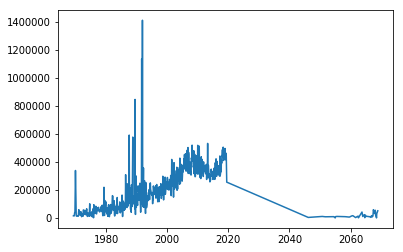

In [50]:
df = pd.read_csv('history_cleaned.csv', parse_dates = ['date'], index_col="date")
df['price'] = df['price'].str.replace(',', '')
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].astype(float)
df=df.dropna()
df=df.astype(int)
print("missing values",df.isnull().sum())

df_monthly = df.resample('M').mean()
df_monthly=df_monthly.dropna()
df_ts = df_monthly.price
df_ts=df_ts.dropna()
plt.plot(df_ts)

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


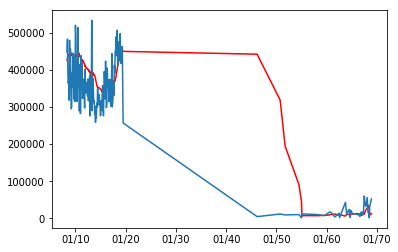

Test RMSE: 74677.522


In [51]:
#ARIMA Model
data_split = 0.7
p = 2
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(df_ts, data_split, params, future_periods, log)

                 t-0       t-1
date                          
2068-03-31  0.351800  0.584402
2068-05-31  0.495820  0.351800
2068-06-30  0.185545  0.495820
2068-07-31  0.955496  0.185545
2068-11-30  0.578543  0.955496


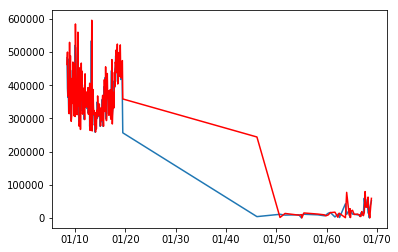

Train RMSE: 189256.947
Test RMSE: 72335.547


In [52]:
#LSTM Model
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 5
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(df_ts, look_back, split, transforms, lstm_params)

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


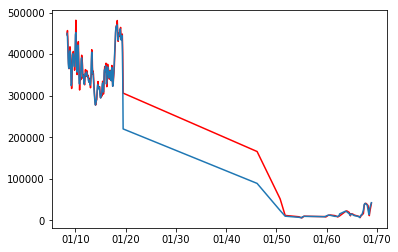

Test RMSE: 14543.371


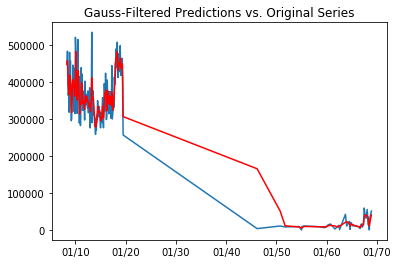

Test RMSE: 35336.025


In [56]:
# running ARIMA model with Gaussian Filter
data_split = 0.7
p = 0
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True
df_ts_gauss=pd.Series(gaussian_filter(df_ts,sigma=1),index=df_ts.index).astype(float)
predictions, test, forecast = arima_model(df_ts_gauss, data_split, params, future_periods, log)

# comparing ARIMA model with Gaussin filter to original series
gauss_compare(df_ts, predictions, data_split)

                 t-0       t-1
date                          
2068-03-31  0.434625  0.582871
2068-05-31  0.356771  0.434625
2068-06-30  0.647466  0.356771
2068-07-31  0.916160  0.647466
2068-11-30  0.796071  0.916160


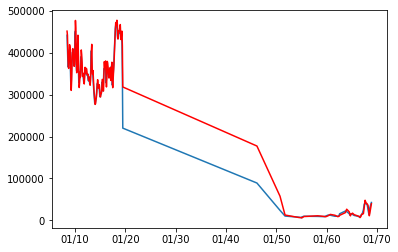

Train RMSE: 32684.161
Test RMSE: 18055.496


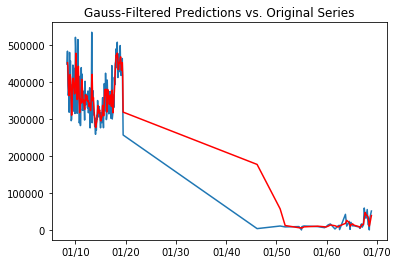

Test RMSE: 38522.341


In [55]:
# running LSTM with Gaussian-filtered data
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 10
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]
df_ts_gauss=pd.Series(gaussian_filter(df_ts,sigma=1),index=df_ts.index).astype(float)
train_predict, y_train, test_predict, y_test = lstm_model(df_ts_gauss, look_back, split, transforms, lstm_params)

# comparing gaussian model results to original data
gauss_compare(df_ts, test_predict, split)